<a href="https://colab.research.google.com/github/ritwiks9635/My_Neural_Network_Architecture/blob/main/Text_classification_using_Decision_Forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Text classification using Decision Forests and pretrained embeddings**

## Introduction

[TensorFlow Decision Forests](https://www.tensorflow.org/decision_forests) (TF-DF)
is a collection of state-of-the-art algorithms for Decision Forest models that are
compatible with Keras APIs. The module includes Random Forests, Gradient Boosted Trees,
and CART, and can be used for regression, classification, and ranking tasks.

In this example we will use Gradient Boosted Trees with pretrained embeddings to
classify disaster-related tweets.

### See also:

- [TF-DF beginner tutorial](https://www.tensorflow.org/decision_forests/tutorials/beginner_colab)
- [TF-DF intermediate tutorial](https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab).



Install Tensorflow Decision Forest using following command :

In [ ]:
pip install tensorflow_decision_forests

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_decision_forests as tfdf

## Get the data

The Dataset is avalaible on [Kaggle](https://www.kaggle.com/c/nlp-getting-started)

Dataset description:

**Files:**

- train.csv: the training set

**Columns:**

- id: a unique identifier for each tweet
- text: the text of the tweet
- location: the location the tweet was sent from (may be blank)
- keyword: a particular keyword from the tweet (may be blank)
- target: in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/IMvision12/Tweets-Classification-NLP/main/train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df.shape

(7613, 5)

In [5]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
df.keyword.value_counts()

fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

Shuffling and dropping unnecessary columns:

In [8]:
df_shuffled = df.sample(frac = 1, random_state = 42)
df_shuffled.drop(["id", "keyword", "location"], axis = 1, inplace = True)
df_shuffled.reset_index(inplace = True, drop = True)
df_shuffled.head()

,text,target
0,So you have a new weapon that can cause un-ima...,1
1,The f$&amp;@ing things I do for #GISHWHES Just...,0
2,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
3,Aftershock back to school kick off was great. ...,0
4,in response to trauma Children of Addicts deve...,0


In [9]:
df_shuffled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7613 non-null   object
 1   target  7613 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 119.1+ KB


Total number of "disaster" and "non-disaster" tweets:

In [10]:
df_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Splitting dataset into training and test sets:

In [11]:
test_df = df_shuffled.sample(frac=0.1, random_state=42)
train_df = df_shuffled.drop(test_df.index)
print(f"Using {len(train_df)} samples for training and {len(test_df)} for validation")

Using 6852 samples for training and 761 for validation


In [16]:
def create_dataset(dataset):
    dataset = tf.data.Dataset.from_tensor_slices(
          (dataset["text"].to_numpy(), dataset["target"].to_numpy()))
    dataset = dataset.batch(100)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_ds =  create_dataset(train_df)
test_ds  =  create_dataset(test_df)

In [17]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Downloading pretrained embeddings

The Universal Sentence Encoder embeddings encode text into high-dimensional vectors that can be
used for text classification, semantic similarity, clustering and other natural language
tasks. They're trained on a variety of data sources and a variety of tasks. Their input is
variable-length English text and their output is a 512 dimensional vector.

To learn more about these pretrained embeddings, see
[Universal Sentence Encoder](https://tfhub.dev/google/universal-sentence-encoder/4).

In [18]:
sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4")

## Creating our models

We create two models. In the first model (model_1) raw text will be first encoded via
pretrained embeddings and then passed to a Gradient Boosted Tree model for
classification. In the second model (model_2) raw text will be directly passed to
the Gradient Boosted Trees model.

In [22]:
inputs = layers.Input(shape = (), dtype = tf.string)
outputs = sentence_encoder_layer(inputs)
preprocessor = keras.Model(inputs, outputs)
model_1 = tfdf.keras.GradientBoostedTreesModel(preprocessing=preprocessor)

Use /tmp/tmp261kaioq as temporary training directory


In [23]:
model_2 = tfdf.keras.GradientBoostedTreesModel()

Use /tmp/tmpg0r8rven as temporary training directory


## Train the models

We compile our model by passing the metrics `Accuracy`, `Recall`, `Precision` and
`AUC`. When it comes to the loss, TF-DF automatically detects the best loss for the task
(Classification or regression). It is printed in the model summary.

Also, because they're batch-training models rather than mini-batch gradient descent models,
TF-DF models do not need a validation dataset to monitor overfitting, or to stop
training early. Some algorithms do not use a validation dataset (e.g. Random Forest)
while some others do (e.g. Gradient Boosted Trees). If a validation dataset is
needed, it will be extracted automatically from the training dataset.

In [24]:
# Compiling model_1
model_1.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model_1.fit(train_ds)

# Compiling model_2
model_2.compile(metrics=["Accuracy", "Recall", "Precision", "AUC"])
# Here we do not specify epochs as, TF-DF trains exactly one epoch of the dataset
model_2.fit(train_ds)

Reading training dataset...
Training dataset read in 0:00:14.323824. Found 6852 examples.
Training model...
Model trained in 0:03:15.948836
Compiling model...
Model compiled.
Reading training dataset...
Training dataset read in 0:00:00.189119. Found 6852 examples.
Training model...
Model trained in 0:00:00.233335
Compiling model...
Model compiled.


Prints training logs of models

In [25]:
logs_1 = model_1.make_inspector().training_logs()
print(logs_1)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3077609539031982, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.6865671873092651, loss=1.2614209651947021, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.7417910695075989, loss=1.2177786827087402, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.7701492309570312, loss=1.1783922910690308, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.7776119112968445, loss=1.1459333896636963, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.7835820913314819, loss=1.1136521100997925, rmse=None, n

In [28]:
logs_2 = model_2.make_inspector().training_logs()
print(logs_2)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=None, accuracy=0.5656716227531433, loss=1.3685380220413208, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=2, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3679413795471191, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=3, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3674567937850952, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=4, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3670554161071777, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=5, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.3667176961898804, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=6, evaluation=Evaluation(num_examples=None, accuracy=0.5686567425727844, loss=1.366430401802063, rmse=None, nd

In [29]:
print("model_1 summary: ")
print(model_1.summary())
print()
print("model_2 summary: ")
print(model_2.summary())

model_1 summary: 
Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 512)               256797824 
                                                                 
Total params: 256797825 (979.61 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 256797825 (979.61 MB)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (512):
	model/keras_layer/StatefulPartitionedCall:0.0
	model/keras_layer/StatefulPartitionedCall:0.1
	model/keras_layer/StatefulPartitionedCall:0.10
	model/keras_layer/StatefulPartitionedCall:0.100
	model/keras_layer/StatefulPartitionedCall:0.101
	model/keras_layer/StatefulPartitionedCall:0.102
	model/keras_layer/StatefulPartitionedCall:0.103
	model/keras_layer/StatefulPartitionedCall:0.104
	model/keras_layer/Stat

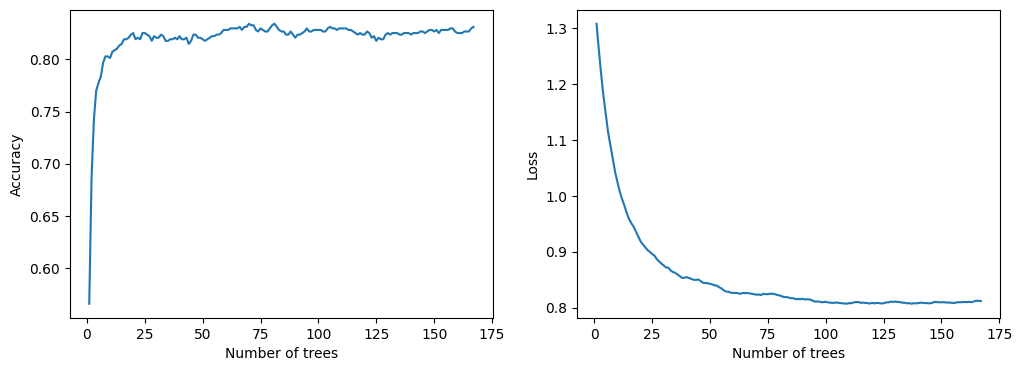

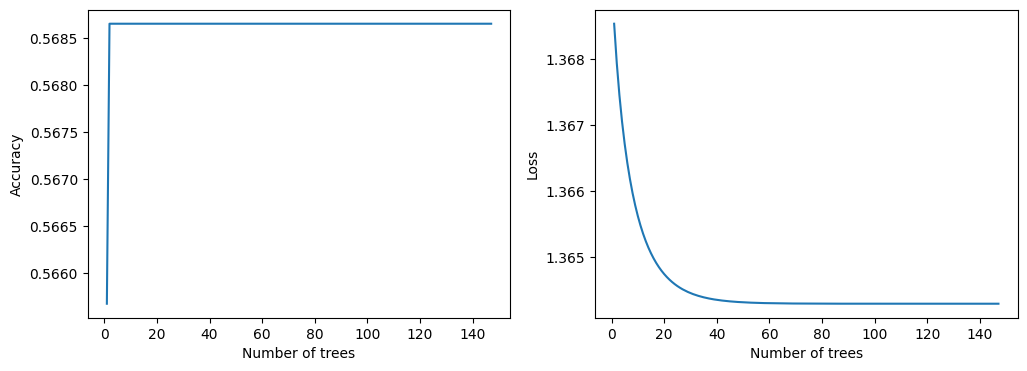

In [30]:
def plot_curve(logs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

    plt.show()


plot_curve(logs_1)
plot_curve(logs_2)

In [31]:
results = model_1.evaluate(test_ds, return_dict=True, verbose=0)
print("model_1 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")


results = model_2.evaluate(test_ds, return_dict=True, verbose=0)
print("model_2 Evaluation: \n")
for name, value in results.items():
    print(f"{name}: {value:.4f}")

model_1 Evaluation: 

loss: 0.0000
Accuracy: 0.8160
recall: 0.7241
precision: 0.8514
auc: 0.8700
model_2 Evaluation: 

loss: 0.0000
Accuracy: 0.5440
recall: 0.0029
precision: 1.0000
auc: 0.5026


In [32]:
test_df.reset_index(inplace=True, drop=True)
for index, row in test_df.iterrows():
    text = tf.expand_dims(row["text"], axis=0)
    preds = model_1.predict_step(text)
    preds = tf.squeeze(tf.round(preds))
    print(f"Text: {row['text']}")
    print(f"Prediction: {int(preds)}")
    print(f"Ground Truth : {row['target']}")
    if index == 10:
        break

Text: DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5
Prediction: 0
Ground Truth : 0
Text: FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday
Prediction: 1
Ground Truth : 0
Text: Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj
Prediction: 1
Ground Truth : 1
Text: @camilacabello97 Internally and externally screaming
Prediction: 0
Ground Truth : 1
Text: Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov
Prediction: 1
Ground Truth : 1
Text: Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8
Prediction: 1
Ground Truth : 1
Text: How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ

## Concluding remarks

The TensorFlow Decision Forests package provides powerful models
that work especially well with structured data. In our experiments,
the Gradient Boosted Tree model with pretrained embeddings achieved 81.6%
test accuracy while the plain Gradient Boosted Tree model had 54.4% accuracy.